___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />


# TERCER EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Nombre: Esteban Limón Ochoa

## Fecha: 21 de Octubre del 2018

## Por: Oscar David Jaramillo Z.

Vamos a suponer que el curso de simulación de procesos financieros es una gran empresa de consultoría financiera que ofrece sus servicios a cualquier tipo de compañía o particular. Supongamos que acuden a nuestra empresa 4 personalidades con los siguientes problemas que desean solucionar:
> 1. El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 
Para cada uno de los clientes, se debe de presentar 4 posibles estrategias de cobertura usando opciones Europeas, Americanas, Barrera y Asiáticas, tipo call ó put. Además de ofrecer al cliente este abanico de posibilidades, ustedes como analistas financieros deben de recomendar la mejor estrategia costo-beneficio (basado en sus cálculos), que debería cada empresa tomar, para cumplir con su objetivo.

> ###  Criterio de evaluación
> - Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.
> - La valuación de cada tipo de opción corresponderá al 20% de la calificación final.
> - La decisión o recomendación basado en sus análisis que le recomendarán a cada compañía corresponderá a 20%.

> ### Entrega
> Se debe de entregar un cuaderno de python donde se reporten todos los cálculos empleados en su análisis. La fecha límite de entrega será el miércoles 28 de noviembre a las 6 pm y se expondrá ese mismo día los resultados obtenidos.

> ### Suposiciones 
> - Deben de definirse correctamente el nombre de las acciones a descargar de Yahoo según la empresa asignada.
> - El examen es individual y códigos idénticos serán penalizados.


### Supuestos para solucionar el problema:
Un agricultor se acerca a nosotros a cubrir su cosecha, la cosecha suponemos que es de 10 hectáreas. Las coberturas de maíz que se ofrecen en el mercado se cotizan en Bushel con el ticker "ZC=F". Cada bushel de maíz equivale a 39.37 toneladas, la cosecha promedio de maíz por hectárea es de 9 toneladas por hectárea. Por lo que debemos de cubrir 3,543.3 bushel de maíz para el 1 de diciembre de 2019, redondeándolo a 5,543 bushel por practicidad. 

La secretaria ASERCA mexicana apoya a los agricultores mexicanos que cultivan maíz con el 75% de los precios de las primas. La secretaría también impide la venta de opciones de venta, limitando a los agricultores a hacer estrategias estructuradas. Por lo que proponemos simplemente comprar un put in the money al precio, con precio del bushel de 368.25 USD. El tipo de cambio es de 20.60 al 26 de noviembre, la cobertura que se presentará está valuada en USD.


### Supuestos para valuar las opciones
A continuación valuaré 4 opciones distintas, Europea, Asiática, Barrera y Americana; las opciones se valúan con rendimientos normales. El supuesto de los rendimientos normales lo probaré comprobando que el rendimiento de los futuros de maíz se puede representar como una distribución normal. Todas las primas se calcularán conun tiempo de 369 días, calculando la opción al primero de diciembre de 2019. Para calcular las primas utilicé la tasa libre de riesgo estadounidense, bonos del tesoro anual que dan un rendimiento de: 2.7%

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like# hack para que jale pd data reader
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
from sklearn.neighbors import KernelDensity
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    if freq == None:
        freq = 'd'
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

Comportamiento del precio del futuro de bushel de maíz desde 2017


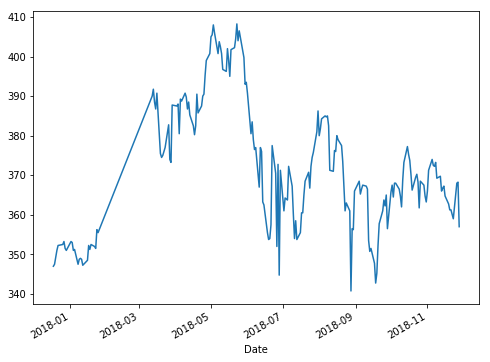

In [3]:
closes = get_closes(['ZC=F'],'2017-01-01')
closes_st = closes.loc[:,'ZC=F']
closes_st.plot(figsize=(8,6))
print('Comportamiento del precio del futuro de bushel de maíz desde 2017')

Comportamiento del rendimiento del futuro de bushel de maíz desde 2017


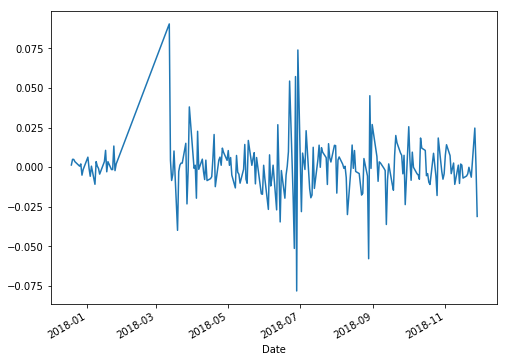

In [4]:
ret_stock = calc_daily_ret(closes_st)
ret_stock.plot(figsize=(8,6));
print('Comportamiento del rendimiento del futuro de bushel de maíz desde 2017')

Las std usando rendimientos logarítmicos y simples son similares


(0.017437864182156974, 0.01733601367074714)

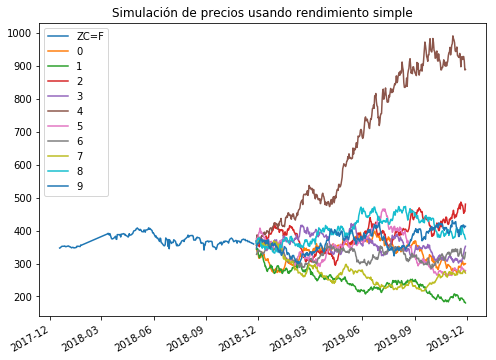

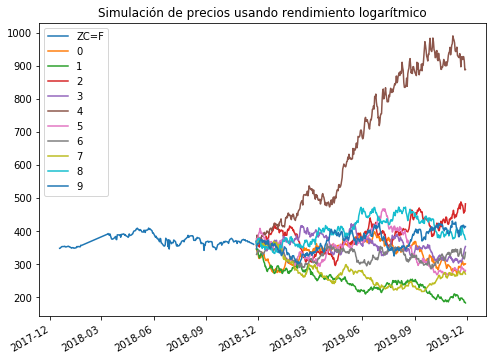

In [5]:
#%% RENDIMIENTOS 

ticker = ['ZC=F']
start_date = '2017-01-01'
closes_st = get_closes(ticker, start_date,freq='d')
closes_st
# Obtenemos el rendimiento simple
Ri = closes_st.pct_change(1).iloc[1:]
# Obtenemos su media y desviación estándar de los rendimientos
mu_R = Ri.mean()[0]
sigma_R = Ri.std()[0]
Ri
ndays = 369#dias a transcurrir
nscen = 10
dates = pd.date_range('2018-11-26', periods = ndays)
dates
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)
# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(mu_R*dt+Z*sigma_R*np.sqrt(dt),index=dates)
Ri_dt.cumprod()
# Simulación del precio
S_0 = closes_st.iloc[-1,0]
S_T = S_0*(1+Ri_dt).cumprod()

# Se muestran los precios simulados con los precios descargados
pd.concat([closes_st,S_T]).plot(figsize=(8,6));
plt.title('Simulación de precios usando rendimiento simple');
#rendimiento logaritmico
ri = calc_daily_ret(closes_st)
# Usando la media y desviación estándar de los rendimientos logarítmicos
mu_r = ri.mean()[0]
sigma_r = ri.std()[0]

# # Usando la equivalencia teórica
# mu_r2 = mu_R - (sigma_R**2)/2

sim_ret_ri = pd.DataFrame(mu_r*dt+Z*sigma_r*np.sqrt(dt), index=dates)
# sim_ret_ri
# Simulación del precio
S_0 = closes_st.iloc[-1,0]
S_T2 = S_0*np.exp(sim_ret_ri.cumsum())

# Se muestran los precios simulados con los precios descargados
pd.concat([closes_st,S_T2]).plot(figsize=(8,6));
plt.title('Simulación de precios usando rendimiento logarítmico');
S_T-S_T2
print('Las std usando rendimientos logarítmicos y simples son similares')
sigma_R,sigma_r

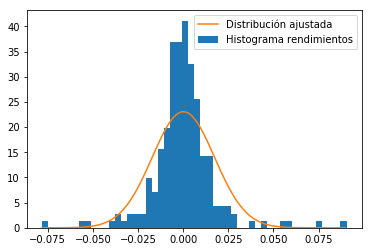

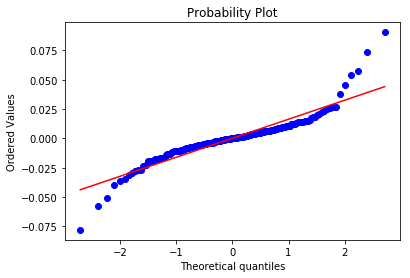

In [6]:
#%% ANALISIS DE RENDIMIENTOS

ren = calc_daily_ret(closes_st) # rendimientos 
y,x,des = plt.hist(ren['ZC=F'],bins=50,density=True,label='Histograma rendimientos')

mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal
# Valores máximo y mínimo de los rendiemientos a generar
ren_max = max(x);ren_min = min(x)
# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
# Generación de la normal ajustado con los parámetros encontrados
curve_fit = st.norm.pdf(ren_gen,loc=mu_fit,scale=sd_fit)
plt.plot(ren_gen,curve_fit,label='Distribución ajustada')
plt.legend()
plt.show()
st.probplot(ren['ZC=F'], dist='norm', plot=plt);

Al revisar el histograma de rendimientos y la gráfica QQ plot podemos decir que los rendimientos se pueden representar como una distribución normal, para así poder valuar los precios de las primas de las opciones. También se puede observar que los rendimientos se pueden expresar de forma logarítmica.

# Cálculo de la opción Europea

In [7]:
S0 = closes_st.iloc[-1,0] 
S0

357.0

In [8]:
ret_stock = calc_daily_ret(closes_st)
#ret_stock.plot(figsize=(8,6));
ret_stock.mean()[0]

0.00013593780781234296

(38.49226381024897, 40.66178285073467)
(38.49226381024897, 40.66178285073467)
precio de la prima modelo normal para rendimientos :  Prima    39.577
Name: 2019-11-29 00:00:00, dtype: float64


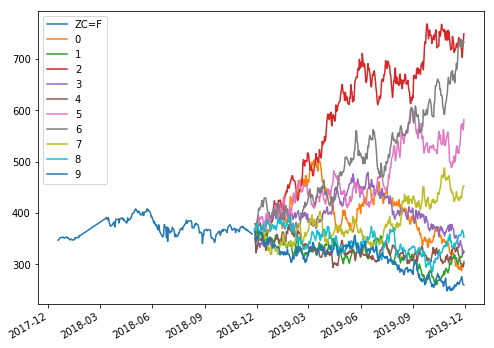

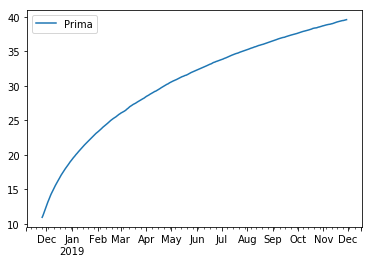

In [9]:
#%%valuacion usando modelo normal para rendimientos

mu = ret_stock.mean()[0]
sigma = ret_stock.std()[0]
mu, sigma
r = 0.027/365 # Tasa diaria
nscen = 10
dates = pd.date_range('2018-11-26', periods = ndays)
dates
#GENERAR 10 ESCENARIOS
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r, index=dates)
sim_ret.cumsum()
# Las columnas son los escenarios y las filas son las días de contrato
S0 = closes_st.iloc[-1,0]  # Condición inicial del precio a simular
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes
#sim_closes.plot(figsize=(8,6));
pd.concat([closes_st,sim_closes]).plot(figsize=(8,6));

K=368.25 # strike price
ndays = 369#dias de la opcion
nscen = 100000
dates = pd.date_range('2018-11-26', periods = ndays)
S0 = closes_st.iloc[-1,0]  # Condición inicial del precio a simular

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul = pd.concat([closes_aapl.T,strike.T,sim_closes.T]).T
#simul.plot(figsize=(8,6),legend=False);
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
putmnr = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(-sim_closes+strike,np.zeros([ndays,nscen])).T.mean()}, index=dates)
putmnr.plot();
#aqui es donde se le mete la ecacion BS put= -st+k
putmnr.iloc[-1]
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = putmnr.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i1)
print('precio de la prima modelo normal para rendimientos : ',putmnr.iloc[-1])

(36.68083167907005, 38.35752748559905)
(36.68083167907005, 38.35752748559905)
precio de la prima usando histograma de rendimientos:  Prima    37.519
Name: 2019-11-29 00:00:00, dtype: float64


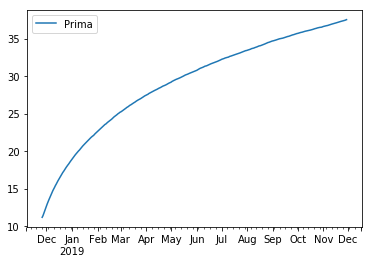

In [10]:
#%%Valuación usando simulación: uso del histograma de rendimientos
prob = y/np.sum(y)
values = x[1:]
ret = np.random.choice(values, ndays*nscen, p=prob)
dates = pd.date_range('2018-11-11',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_ret_hist
sim_closes_hist = (closes_st.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
sim_closes_hist
# K=368.25
# ndays = 369
#nscen = 10000
freq, values = np.histogram(ret_stock+r-mu, bins=2000)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
dates=pd.date_range('2018-11-26',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_st.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays) \
                          *np.fmax(-sim_closes_hist+strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
put_hist.plot();
#aqui es donde se le mete la ecacion BS put= -st+k
put_hist.iloc[-1]
#INTERVALO DE CONFIANZA
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i1)
print('precio de la prima usando histograma de rendimientos: ',put_hist.iloc[-1])

In [11]:
print('precios de las primas usando los distintos modelos')
print('precio de la prima modelo normal para rendimientos : ',float(putmnr.iloc[-1]))
print('precio de la prima usando histograma de rendimientos: ',float(put_hist.iloc[-1]))
pn=float(putmnr.iloc[-1])
ph=float(put_hist.iloc[-1])
pm=(pn+ph)/2
print('precio medio de la opción europea: ',pm)

precios de las primas usando los distintos modelos
precio de la prima modelo normal para rendimientos :  39.57702333049182
precio de la prima usando histograma de rendimientos:  37.51917958233455
precio medio de la opción europea:  38.548101456413185


# Cálculo de la prima de la opción asiática:

In [12]:
T=369/365
S0,K,T,r,sigma

(357.0, 368.25, 1.010958904109589, 7.397260273972603e-05, 0.01733601367074714)

In [13]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    T = 1
    nu = mu-(sigma**2)/2
    
    DeltaT = T/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    
    #for i in range(NbStep):
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt)
    t = np.arange(0,1,DeltaT)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [14]:
def Riemann_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    #iniciamos el conteo de tiempo
    ts=time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(-Average_t+strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    #finalizamos el tiempo
    tf=time.time()
    tottime=(tf-ts)
    return put.iloc[-1].Prima#caso particular en clase, solo visualizar la prima
    #return np.array([put.iloc[-1].Prima,i1[0],i1[1],tottime])#caso para observar max, min tiempo y prima

In [15]:
#put caso particular, solo observar prima
NbTraj = [1000,5000,10000]
NbStep = [10,50,100]


put= np.zeros([len(NbTraj),len(NbStep)])
# intervalos = []#np.zeros([len(NbTraj),len(NbStep)])
M = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach_put(K,r,S0,N_tra,N_ste,sigma),
                                   NbStep)),
                                   NbTraj))
M = np.asmatrix(M)
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = M
df

,NbStep = 10,NbStep = 50,NbStep = 100
Nbtray = 1000,11.070,11.237,11.215
Nbtray = 5000,11.212,11.281,11.207
Nbtray = 10000,11.163,11.296,11.236


In [33]:
opa=M[1,1]
opa

11.28146102909927

En el caso de la opción asiática, la cual paga l precio promedio del suyacente en caso de ejercerse, es de tan solo $1.4 USD por bushel que se desea cubrir. Esta opción no es la mejor, ya que solo paga un precio promedio de la prima.

# Valuación de opción Up and Out
Ya que el agricultur se quiere cubrir de una baja de los precios del maíz, opte por ofrecerle una opción Up and out, desactivandose, cuando el escenario pinta para que el agricultor no utilice su opción al corto plazo.

In [17]:
B=385
mu,sigma,r,K,S0,T,B,ndays,nscen

(0.00013593780781234296,
 0.01733601367074714,
 7.397260273972603e-05,
 368.25,
 357.0,
 1.010958904109589,
 385,
 369,
 100000)

In [18]:
BPUO=B;# BARRERA PUT UP AND OUT
barrierpuo = pd.DataFrame(BPUO*np.ones((ndays, nscen)),index=dates)
IPUO= (sim_closes>barrierpuo).cumsum()>0
IPUO

,0,1,2,...,99997,99998,99999
2018-11-26,False,False,False,...,False,False,False
2018-11-27,False,False,False,...,False,False,False
2018-11-28,False,False,False,...,False,False,False
2018-11-29,False,False,False,...,False,False,False
2018-11-30,False,False,False,...,True,False,False
...,...,...,...,...,...,...,...
2019-11-25,True,True,False,...,True,True,True
2019-11-26,True,True,False,...,True,True,True
2019-11-27,True,True,False,...,True,True,True
2019-11-28,True,True,False,...,True,True,True


Prima Europea    39.577
Name: 2019-11-29 00:00:00, dtype: float64
Prima Put Up & Out    18.923
Name: 2019-11-29 00:00:00, dtype: float64


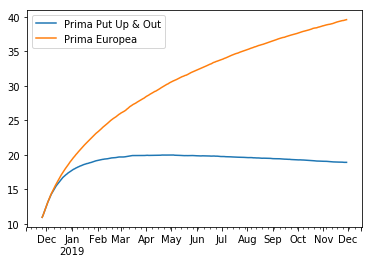

In [19]:
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(-sim_closes+strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
putuo = pd.DataFrame({'Prima Put Up & Out':np.exp(-r*ndays)*(-IPUO*np.fmax(-sim_closes+strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

ax=putuo.plot();
put.plot(ax=ax);

print(put.iloc[-1])

print(putuo.iloc[-1])

Esta opción es muy atractiva para un agricultor, ya que estas vendiendo y se te desactiva la opción cuando el precio del subyacente se encarece y por ende el agricultor le es más conveniente vender a mercado. La deficiencia de esta cobertura es que en caso de que el subyacente baje él ya no estará cubierto.

# Valuación de opción américana
Al agricultor se le presenta una 4 estrategia, la cual es más especulativa que de cobertura.

In [20]:
#importar paqueteria Quantlib para valuar opciones americanas
import QuantLib as ql 
import matplotlib.pyplot as plt
%matplotlib inline
print('versión de quantlib',ql.__version__)

versión de quantlib 1.14


In [21]:
B=385
mu,sigma,r,K,S0,T,B,ndays,nscen

(0.00013593780781234296,
 0.01733601367074714,
 7.397260273972603e-05,
 368.25,
 357.0,
 1.010958904109589,
 385,
 369,
 100000)

In [22]:
#aproximación de la volatilidad implicita
simpl=sigma*13
simpl

0.22536817771971282

In [23]:
# option data
maturity_date = ql.Date(29,11,2019)
spot_price = S0
strike_price = 390
volatility =simpl # the historical vols or implied vols
dividend_rate =  0
option_type = ql.Option.Put

risk_free_rate = .027
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(26,11,2018)
ql.Settings.instance().evaluationDate = calculation_date

In [24]:
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date

am_exercise = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)

eu_exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, eu_exercise)

In [25]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)

In [26]:
steps = 1000
binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
american_option.setPricingEngine(binomial_engine)
european_option.setPricingEngine(binomial_engine)
print ('precio de la opción americana',american_option.NPV())
print ('precio de la opción europea calculada con volatilidad implicita',european_option.NPV())

precio de la opción americana 47.49187403356103
precio de la opción europea calculada con volatilidad implicita 45.638872624841845


In [27]:
def binomial_price(option, bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    option.setPricingEngine(binomial_engine)
    return option.NPV()

steps = range(5, 1000, 1)
eu_prices = [binomial_price(european_option, bsm_process, step) for step in steps]
am_prices = [binomial_price(american_option, bsm_process, step) for step in steps]
# theoretican European option price
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()

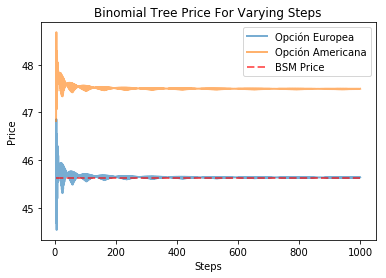

In [28]:
plt.plot(steps, eu_prices, label="Opción Europea", lw=2, alpha=0.6)
plt.plot(steps, am_prices, label="Opción Americana", lw=2, alpha=0.6)
plt.plot([5,1000],[bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
#plt.ylim(6.7,7)
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()

La opción americana que se puede ejercer todos los días del periodo para vender el grano en 390 por bushel, cuesta 38.25 USD. Por lo que si se quiere especular con el precio del maíz y se cree que algún día el subyacente llegará a ese precio, se pueda vender el maíz a $390, pero en caso de subir el precio del subyacente antes de que esté listo la cosecha, no podrá vender el grano. Este tipo de opciones son útiles para coberturas cambiarias, especulación y acciones.

In [40]:
#comparativa de precios
opcion=(['Op Am Modelo normal rendimientos','Op Am Histograma de rendimientos','Opción Asiatica','Opción Barrera',
         'Opción Américana','Opción Europea Vol Impl'])
strike=(['368.25','368.25','368.25','368.25','390','390'])
barrera=(['','','','385','',''])

precio=([pn,ph,opa,float(putuo.iloc[-1]),american_option.NPV(),european_option.NPV()])


df = pd.DataFrame(index=opcion,columns=['Precio Opción','Strike','Barrera'])
df.index.name = "Tipo de Opción"
df['Precio Opción'] = precio
df['Strike'] = strike
df['Barrera'] = barrera
df

,Precio Opción,Strike,Barrera
Tipo de Opción,,,
Op Am Modelo normal rendimientos,39.577,368.25,
Op Am Histograma de rendimientos,37.519,368.25,
Opción Asiatica,11.281,368.25,
Opción Barrera,18.923,368.25,385
Opción Américana,47.495,390,
Opción Europea Vol Impl,45.638,390,


# Conclusión:
La recomendación para el agricultor es comprar opciones europeas, apoyado por ASERCA, ya que ellos apoyan con el 75% de la prima. Las opciones americanas sugerí comprarlas con fines de cobertura para vender la producción en 368.25 el bushel, por lo que el productor pagará $1,129,868.49 pesos para cubrir la producción de sus 10 hectáreas de maíz, que equivale a 5,543 bushel.

In [3]:
ccob=.25*5543*20.6*39.58
apgob=.75*5543*20.6*39.58
print('El costo que el agricultor paga por su cobertura es de: $',ccob,' MXN')
print('El apoyo gubernamental que aporta ASERCA por la cobertura es de: $', apgob, ' MXN')

El costo que el agricultor paga por su cobertura es de: $ 1129868.491  MXN
El apoyo gubernamental que aporta ASERCA por la cobertura es de: $ 3389605.473  MXN
